In [1]:
from IPython.display import clear_output
import numpy as np
from framework.io import Reader, Writer
from framework.base import Dataset
from framework.reconstruction import Parameter
from framework.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.objectivefunction import OFunction
from framework.utils import real_to_complex, complex_to_real, find_pixel
from framework.objectivefunction import TSV, TV, L1, Chi2
from framework.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.utils import Gaussian
from framework.transformers import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools

In [2]:
# Read data
P = np.load("polarized_emission.npy")
#P = np.load("P231_544.npy")
sigma = np.load("sigmas.npy")
nu = np.load("freqs.npy")

In [3]:
measurements = Dataset(nu=nu, data=P, sigma=sigma, spectral_idx=1)

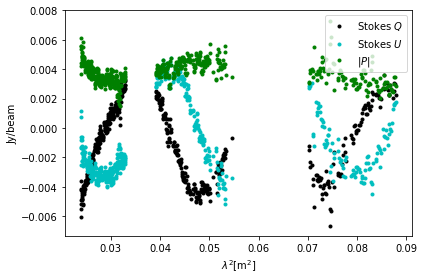

In [4]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

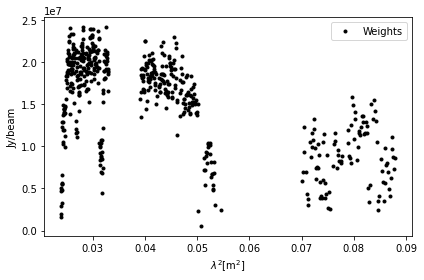

In [5]:
plt.plot(measurements.lambda2, measurements.w, 'k.', label=r"Weights")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc='upper right')
plt.tight_layout()

In [6]:
parameter = Parameter()

In [7]:
parameter.calculate_cellsize(dataset=measurements)

FWHM of the main peak of the RMTF: 54.084 rad/m^2
Maximum recovered width structure: 131.556 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 14737.933


In [8]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [9]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [10]:
F_dirty = dft.backward(measurements.data)

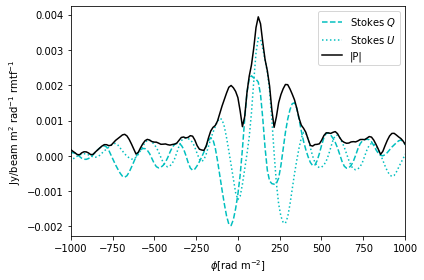

In [11]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [12]:
idx_noise = np.where(np.abs(parameter.phi)>14000)
noise_F = np.std(0.5*(F_dirty[idx_noise].real + F_dirty[idx_noise].imag))
#noise_F = np.std(sigma)
noise_F

2.3102231e-05

In [13]:
P_back = nufft.forward_normalized(F_dirty)

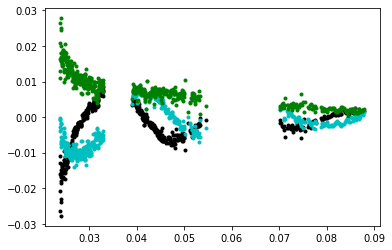

In [14]:
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [15]:
F_back = nufft.backward(measurements.data)

(-1000.0, 1000.0)

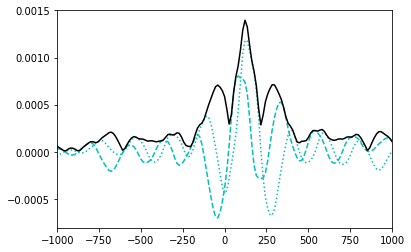

In [16]:
plt.plot(parameter.phi, F_back.real, 'c--', label=r"Real part")
plt.plot(parameter.phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(parameter.phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000,1000])

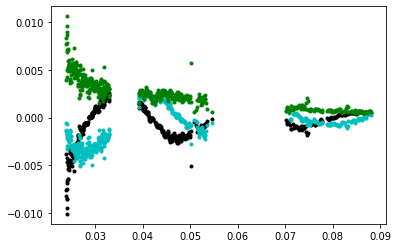

In [17]:
P_back = nufft.forward_normalized(F_back)
plt.plot(measurements.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [18]:
lambda_l1 = np.sqrt(2.0 * measurements.m + 4.0 * np.sqrt(measurements.m))*noise_F
#lambda_l1 /= 2
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [19]:
len(F_back)

2176

In [20]:
len(parameter.data)

2176

In [21]:
parameter.data = F_back

In [22]:
parameter.n

2176

In [23]:
parameter.complex_data_to_real()

In [24]:
nufft.parameter.n

2176

In [25]:
parameter.n

4352

In [26]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_F, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 34
Iteration:  0  objective function value: 49851.57112


(-1000.0, 1000.0)

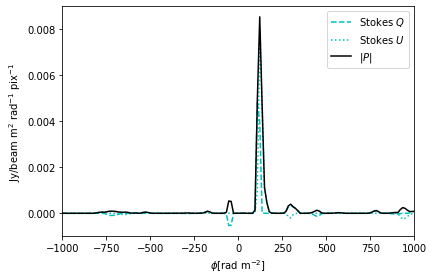

In [27]:
X.real_data_to_complex()

plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

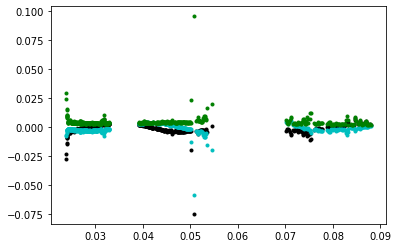

In [28]:
plt.plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
#plt.ylim([-0.007,0.008])

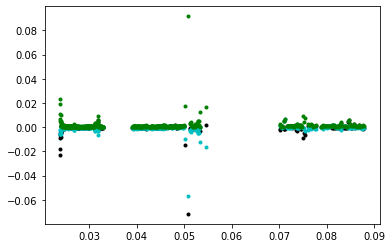

In [29]:
plt.plot(measurements.lambda2, measurements.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.residual), 'g.', label=r"$|P|$")

In [30]:
gridding = Gridding(measurements)

In [31]:
gridded_data = gridding.run()

In [32]:
np.mean(gridded_data.residual.real)

-0.00011118452

In [33]:
np.mean(gridded_data.residual.imag)

-0.00017944982

In [34]:
hist_real,bins_real,hist_imag,bins_imag = gridded_data.histogram_residuals()

<BarContainer object of 11 artists>

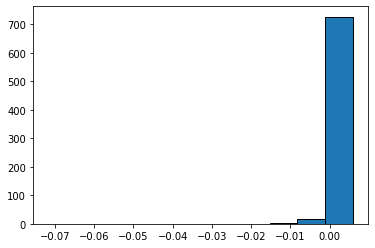

In [35]:
plt.bar(bins_real[:-1], hist_real, width=np.diff(bins_real), edgecolor="black", align="edge")

(-1000.0, 1000.0)

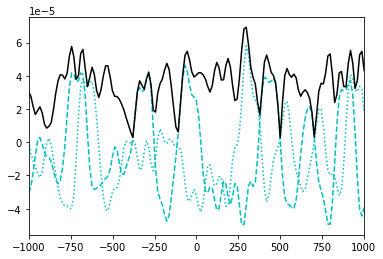

In [36]:
F_residual = nufft.backward(measurements.residual)
plt.plot(parameter.phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])

In [37]:
lags, autocorr_res, bound, percentage_real_in, percentage_imag_in = gridded_data.assess_residuals()

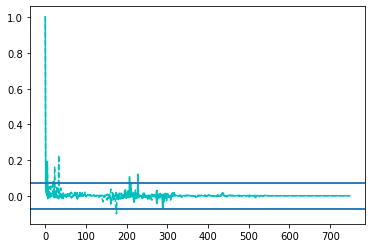

In [38]:
plt.plot(lags, autocorr_res.real, 'c-', label=r"Real part")
plt.plot(lags, autocorr_res.imag, 'c--', label=r"Imaginary part")
plt.axhline(-bound)
plt.axhline(bound)
plt.axhline(-bound)
plt.axhline(bound)
plt.grid()
plt.grid()

In [39]:
percentage_real_in, percentage_imag_in

(99.3324432576769, 99.19893190921228)

In [40]:
conv_model = X.convolve() + F_residual

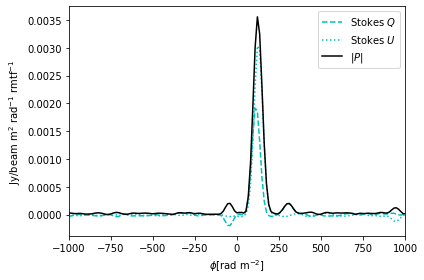

In [41]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("restored.png", dpi=100)

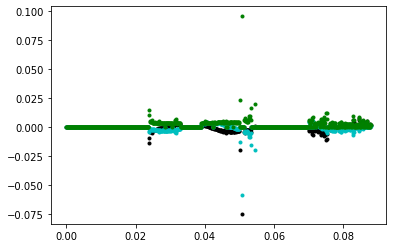

In [42]:
plt.plot(gridded_data.lambda2, gridded_data.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(gridded_data.lambda2, gridded_data.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(gridded_data.lambda2, np.abs(gridded_data.model_data), 'g.', label=r"$|P|$")

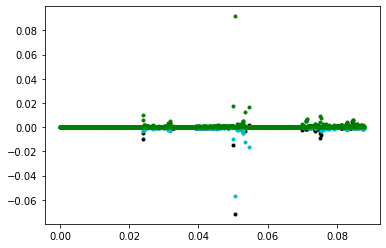

In [43]:
plt.plot(gridded_data.lambda2, gridded_data.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(gridded_data.lambda2, gridded_data.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(gridded_data.lambda2, np.abs(gridded_data.residual), 'g.', label=r"$|P|$")

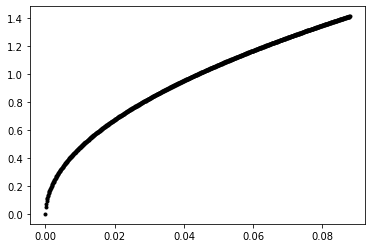

In [44]:
plt.plot(gridded_data.lambda2, gridded_data.s, 'k.', label=r"Spectral_idx")